# Проектная работа на тему: "Основы машинного обучения"

## Описание проекта
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.  
Требуется провести анализ и подготовить план действий по удержанию клиентов в данной сети:
- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  
1) выделить целевые группы клиентов;  
2) предложить меры по снижению оттока;  
3) определить другие особенности взаимодействия с клиентами.  

## Описание данных

Данные клиента за предыдущий до проверки факта оттока месяц:  
'gender' — пол;  
'Near_Location' — проживание или работа в районе, где находится фитнес-центр;  
'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);  
Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
'Phone' — наличие контактного телефона;  
'Age' — возраст;   
'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах). 


Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:  
'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);  
'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);  
'Group_visits' — факт посещения групповых занятий;  
'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;  
'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;  
'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.  
'Churn' — факт оттока в текущем месяце.  

## Загрузка и исследовательский анализ данных 

### Загрузка и подготовка данных

Загрузим необходимые для работы библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Проверим на наличие дубликатов

In [4]:
df.duplicated().sum()

0

Переведем названия столбцов в нижний регистр

In [5]:
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [6]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


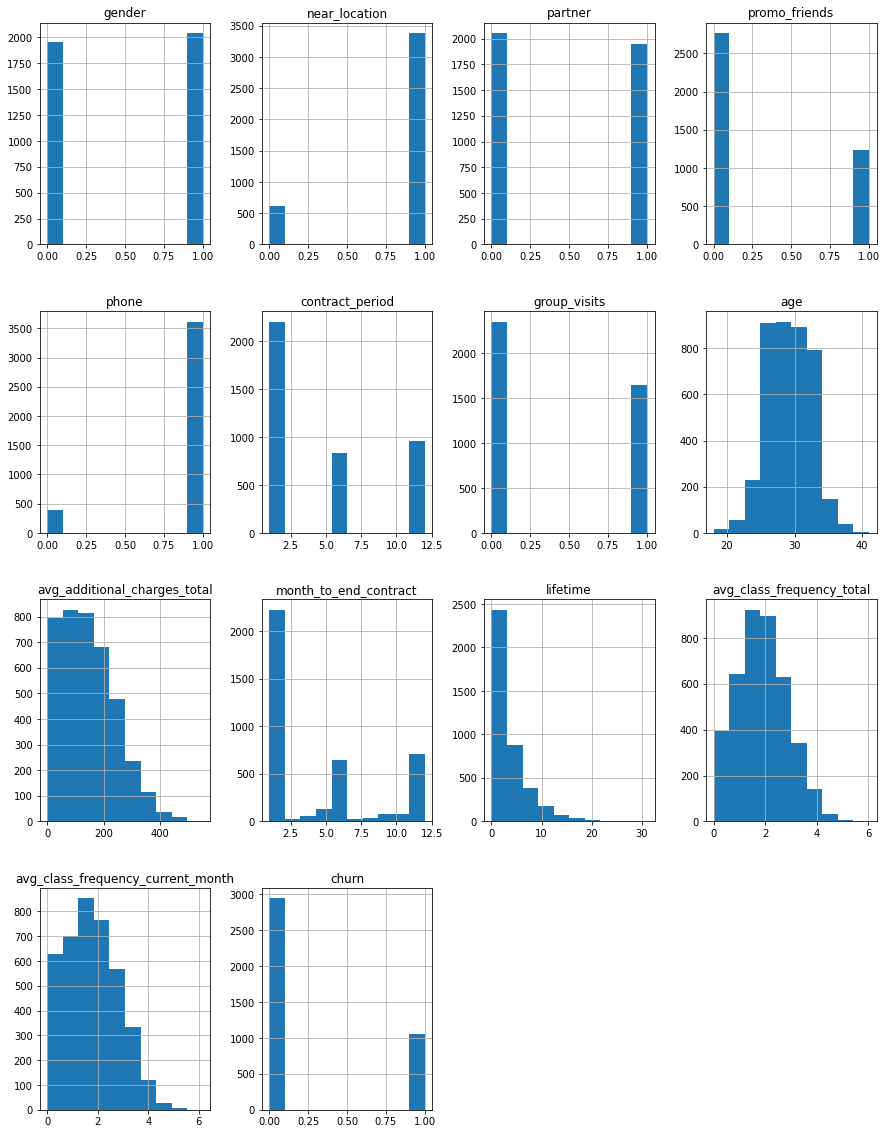

In [7]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax = ax);

Датасет состоит из 4000 строк и 14 столбцов. 8 столбцов: gender, near_location,	partner, promo_friends, phone, contract_period и churn относятся к категориальным данным. 6 столбцов: age, avg_additional_charges_total, month_to_end_contract, lifetime, avg_class_frequency_total, avg_class_frequency_current_month к количественным. Пропущенные данные и дубликаты отсутствуют.  
Исходя из статистик и графиков, полученных с помощью метода describe() и hist(), можно слелать следующие наблюдения: 
- Пол распределен клиентов распределен примерно поровну;
- Преобладают клиенты проживающие или работающие в районе, где находится фитнес-центр (85%);
- Клиент является сотрудником компании-партнёра клуба, примерно в половине случаев;
- 31% клиентов использовали промо-код от знакомого при оплате первого абонемента в рамках акции «приведи друга».
- 90% клиентов оставляют контактный номер телефона;
- Преобладают клиенты с контрактом на 1 месяц.
- 41% клиентов посещают групповые занятия.
- Средний возраст клиентов - 29 лет.
- Средняя суммарная выручка от других услуг фитнес-центра - 147 у.е.
- Наиболее распрастраненный срок до окончания текущего действующего абонемента - 1 мес., средный срок до окончания абонемента - 4,3 мес.
- Среднее время с момента первого обращения в фитнес-центр клиентов - 3,72 мес.
- Средняя частота посещений в неделю за все время с начала действия абонемента - 1,88 в неделю.
- Средняя частота посещений в неделю за предыдущий месяц;ц - 1,77 в неделю.
- 26% отток клиентов в текущем месяце.

### Средние значения признаков в двух группах — тех, кто остался и тех, кто ушел в отток .

In [8]:
mean_feature = df.groupby('churn').mean()
mean_feature

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Выделяется большая разница в средних значениях у следующий, вполне ожидаемых, признаков:
- contract_period (длительность текущего действующего абонемента) - 5,8 мес. у тех кто остался и 1,7 мес. у тех кто ушел в отток;
- lifetime (время с момента первого обращения в фитнес-центр) 4,7 мес. у тех кто остался и 1 мес. у тех кто ушел в отток 
- month_to_end_contract (срок до окончания текущего действующего абонемента) 5.3 мес. у тех кто остался и 1,6 мес. у тех кто ушел в отток 

### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

Составим списки с категориальными и количественными признаками и построим столбцатые диаграммы.

In [9]:
category_feature = ['contract_period', 'gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

In [10]:
numeric_feature = ['age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month']

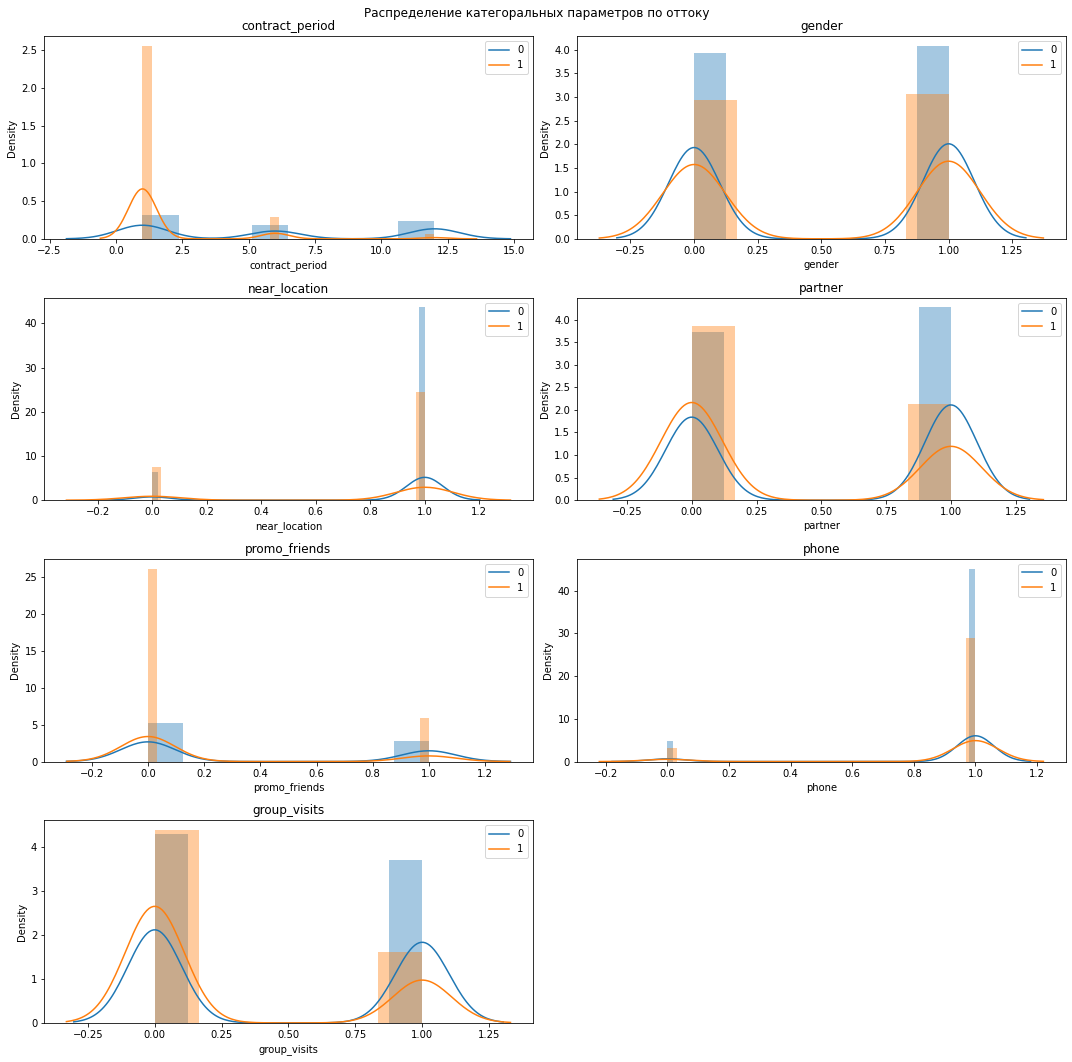

In [11]:
col_count, row_count = 2, 4
plt.figure(figsize=(15, 15))
for i, j in enumerate(category_feature ):
    for churn in df['churn'].unique():
        label=df['churn'].unique()
        current = df.query('churn == @churn')
        sns.distplot(current[j], ax=plt.subplot(row_count, col_count, i+1))
    plt.title(j)
    plt.legend(df['churn'].unique())
plt.suptitle('Распределение категоральных параметров по оттоку')
plt.tight_layout()

Наибольшее количество клиентов, попавших в отток с длительностью текущего действующего абонемента в 1 месяц.
По полу клиенты распределены примерно поровну для тех, кто ушёл и тех, кто остался.    
Тех клиентов, кто живет недалеко (near_location), заметно большее количество, не попавших в отток.   
Такая же картина по признаку partner. Сотрудники компании-партнёра клуба реже попадают в отток.  
Клиенты, пришедшие по акции "Приведи друга" реже остальных попадают в отток.  
Клиенты с указаным номером контактного телефона, реже попадают в отток.    
Клиенты, посещающие групповые программы, реже попадают в отток.  

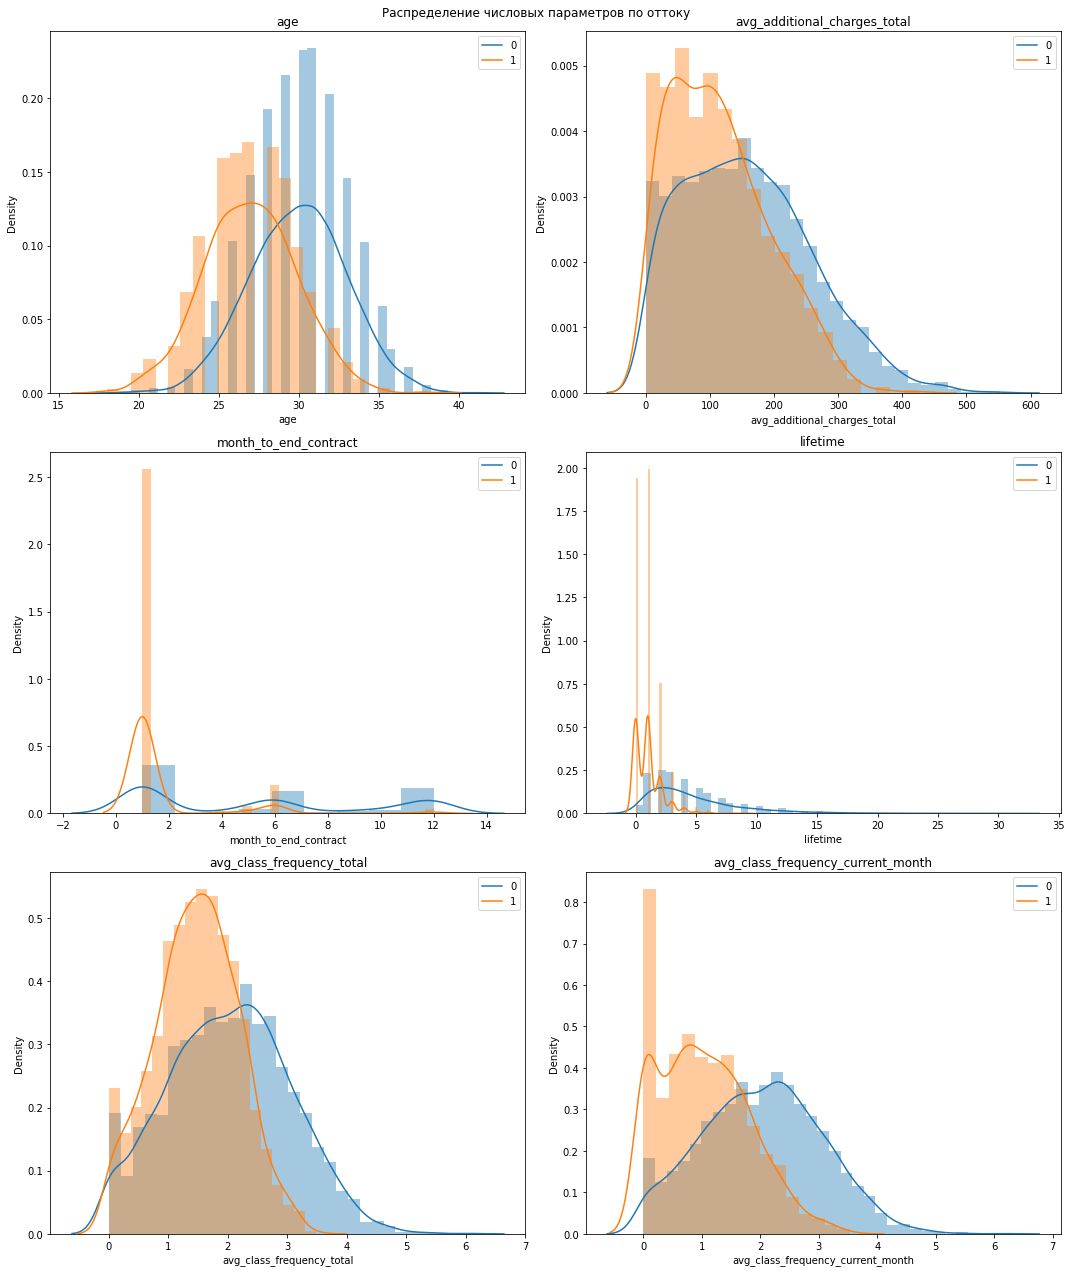

In [12]:
col_count, row_count = 2, 3
plt.figure(figsize=(15, 18))
for i, j in enumerate(numeric_feature ):
    for churn in df['churn'].unique():
        current = df.query('churn == @churn')
        sns.distplot(current[j], ax=plt.subplot(row_count, col_count, i+1))      
    plt.title(j) 
    plt.legend(df['churn'].unique())
plt.suptitle('Распределение числовых параметров по оттоку')
plt.tight_layout()

Среднее значение возраста клиентов попавших в отток меньше, чем  у оставшихся клиентов.  
Средняя суммарная выручка от других услуг фитнес-центра у оставшихся клиентов выше.   
Наиболее частый срок до окончания текущего действующего абонемента у клиентов папавших в отток - 1 мес.  
Наибольлее частое время с момента первого обращения в фитнес-центр, у тех кто ушёл каже 1 мес.  
Средняя частота посещений в неделю за все время с начала действия абонемента и средняя частота посещений в неделю за предыдущий месяц у оставшихся клиентов выше.

### Матрица корреляций.

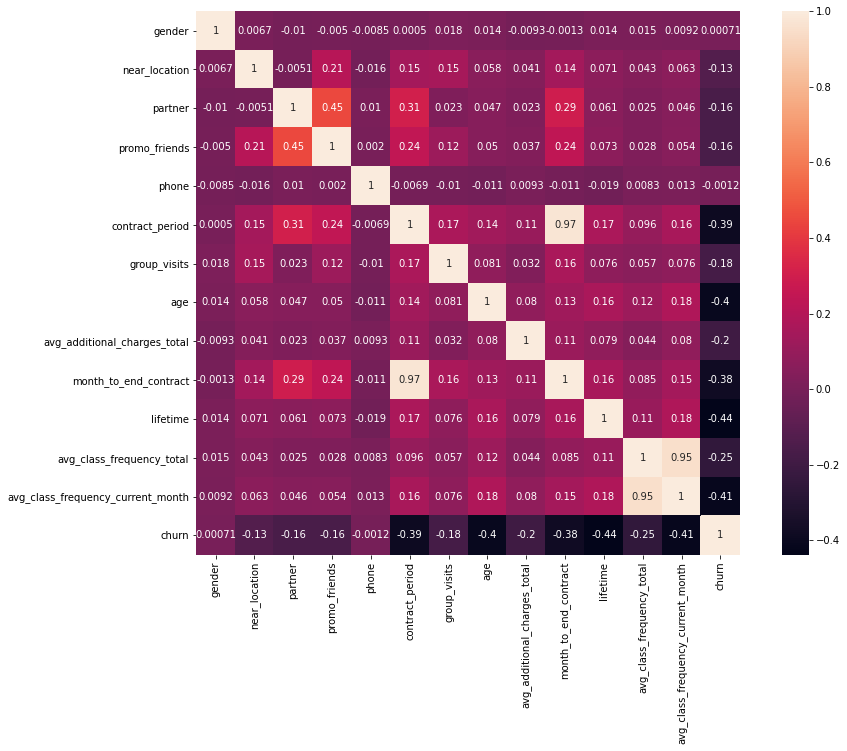

In [13]:
cm = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, annot=True, square=True)
plt.show()

По матрице видно, что сильно коррелирую следующие признаки:  
- Month_to_end_contract - Contract_period (срок до окончания текущего действующего абонемента (в месяцах) - длительность текущего действующего абонемента (месяц, 6 месяцев, год));  
- Avg_class_frequency_total - Avg_class_frequency_current_month (средняя частота посещений в неделю за все время с начала действия абонемента -  средняя частота посещений в неделю за предыдущий месяц).  

Чтобы избавиться от мультиколлинеарности удалим по одному из коррелирующих признаков.

In [14]:
df_filtered = df.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)
df_filtered.shape

(4000, 12)

## Построение модели прогнозирования оттока клиентов.

Обозначим целевую переменную (факт оттока клиента в следующем месяце) - y и набор значений признаков X.

In [15]:
y = df_filtered['churn']
X = df_filtered.drop(['churn'], axis=1)

Разобьём данные на обучающую и валидационную выборку

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Проведем стандартизацию данных

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель на train-выборке двумя способами:
- логистической регрессией,
- случайным лесом.  

Логистическая регрессия:

In [18]:
lr_model = LogisticRegression(solver='liblinear', random_state=0)
lr_model.fit(X_train_st, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [19]:
lr_predictions = lr_model.predict(X_test_st) 
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1] 

Случайный лес

In [20]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(random_state=0)

In [21]:
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке.

In [22]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))

Accuracy: 0.90
Precision: 0.79
Recall: 0.82


In [23]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Accuracy: 0.90
Precision: 0.81
Recall: 0.75


Доля правильных ответов (Accuracy) в данном случае непоказательна, т.к. не выполняется условие баланса классов целевой переменной. Доля оттока составляет в нашей выборке составляет 26%.  
Точность (Precision) выше у модели случайного леса (81% против 79%).  
Полнота (Recall) выше у модели логистической регресии (82% против 75%).
По полноте логистическая регрессия превосходит модель случайного леса, таким образом, логическая регрессия показала чуть лучшие результаты.

## Кластеризация клиентов

### Стандартизация данных

In [24]:
scaler = StandardScaler()
x_sc = scaler.fit_transform(X)

### Расчёт матрицы расстояний, отображение дендрограмм

In [25]:
linked = linkage(x_sc, method = 'ward') 

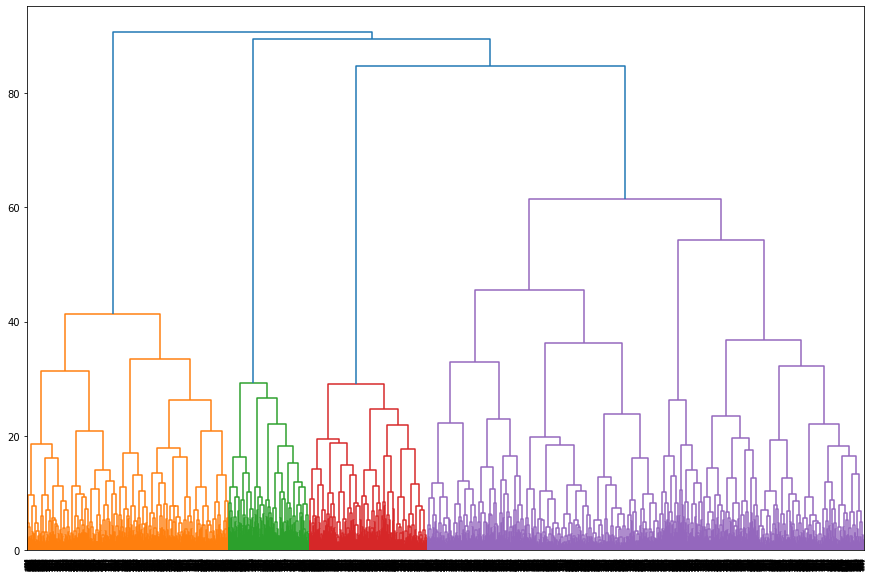

In [26]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

По полученной дендрограмме можно выделить 4 кластера.

### Обучиние модель кластеризации на основании алгоритма K-Means.

Задаём модель k_means с числом кластеров 5 и фиксируем значение random_state

In [27]:
km = KMeans(n_clusters=5, random_state=0)

In [28]:
labels = km.fit_predict(x_sc)

In [29]:
df_filtered['cluster'] = labels 

Посмотрим на средние значения признаков для кластеров.

In [30]:
df_filtered.groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,
0,0.496447,0.995939,0.892386,1.000000,1.0,6.922843,0.524873,29.606091,153.424651,4.283249,1.919520,0.119797
1,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
2,0.500940,1.000000,0.217105,0.072368,1.0,2.010338,0.277256,27.583647,119.339956,1.922932,1.203319,0.563910
3,0.534260,0.996028,0.379345,0.009930,1.0,6.208540,0.538232,30.699106,176.259567,5.415094,2.324220,0.014896
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839


Лидер по доли оттока кластер №2 - 56%. У данного кластера минимальные значения по доле сотрудников компании-партнера (Partner),  по длительности текущего действующего абонемента (contract_period), по возрасту клиентов (age), по времени с момента первого обращения в фитнес-центр (lifetime), по суммарной выручки от других услуг фитнес-центра (avg_additional_charges_total),  по средней частоте посещений в неделю за предыдущий месяц (avg_class_frequency_current_month). При этом 100% клиентов из этого кластера живут или работают в районе фитнесс-центра. Клиентам из этого крастера, не подошли занятия в фитнес-центре, минимальный lifetime, примерно равный contract_period, говорит, что они пришли в фитнес-центр попробовать позаниматься.  

Минимальная доля оттока у кластера №3 - 1,5%. У кластера средний показатель по доле сотрудников компании-партнера (Partner) - 38% и минимальный по факту первоначальной записи в рамках акции «приведи друга» - около 1%. Все остальные признаки в максимальных значениях. В этот кластер попали люди, которые сами рашили серьезно заниматься фитнесом, что подтверждает минимальное значение по акции "приведи друга" и практически все максимальные значения по остальным признакам.

Кластер №0 с невысокой долей оттока - 12%. Выделяется тем, что 100% клиентов пришли по акции «приведи друга». Максимальный среди всех показатель длительности текущего абонемента и доли сотрудников компании-партнёра клуба, говорит, что к этому кластеру относятся клиенты, которых работают недалеко и их устраивает занятия в фитнесс-клубе.

У кластера №1 высокий процент оттока - 40%. Все клиенты живут/работают далеко - near_location (0%). Отсюда такой высокий отток.

Построим распределения признаков для кластеров

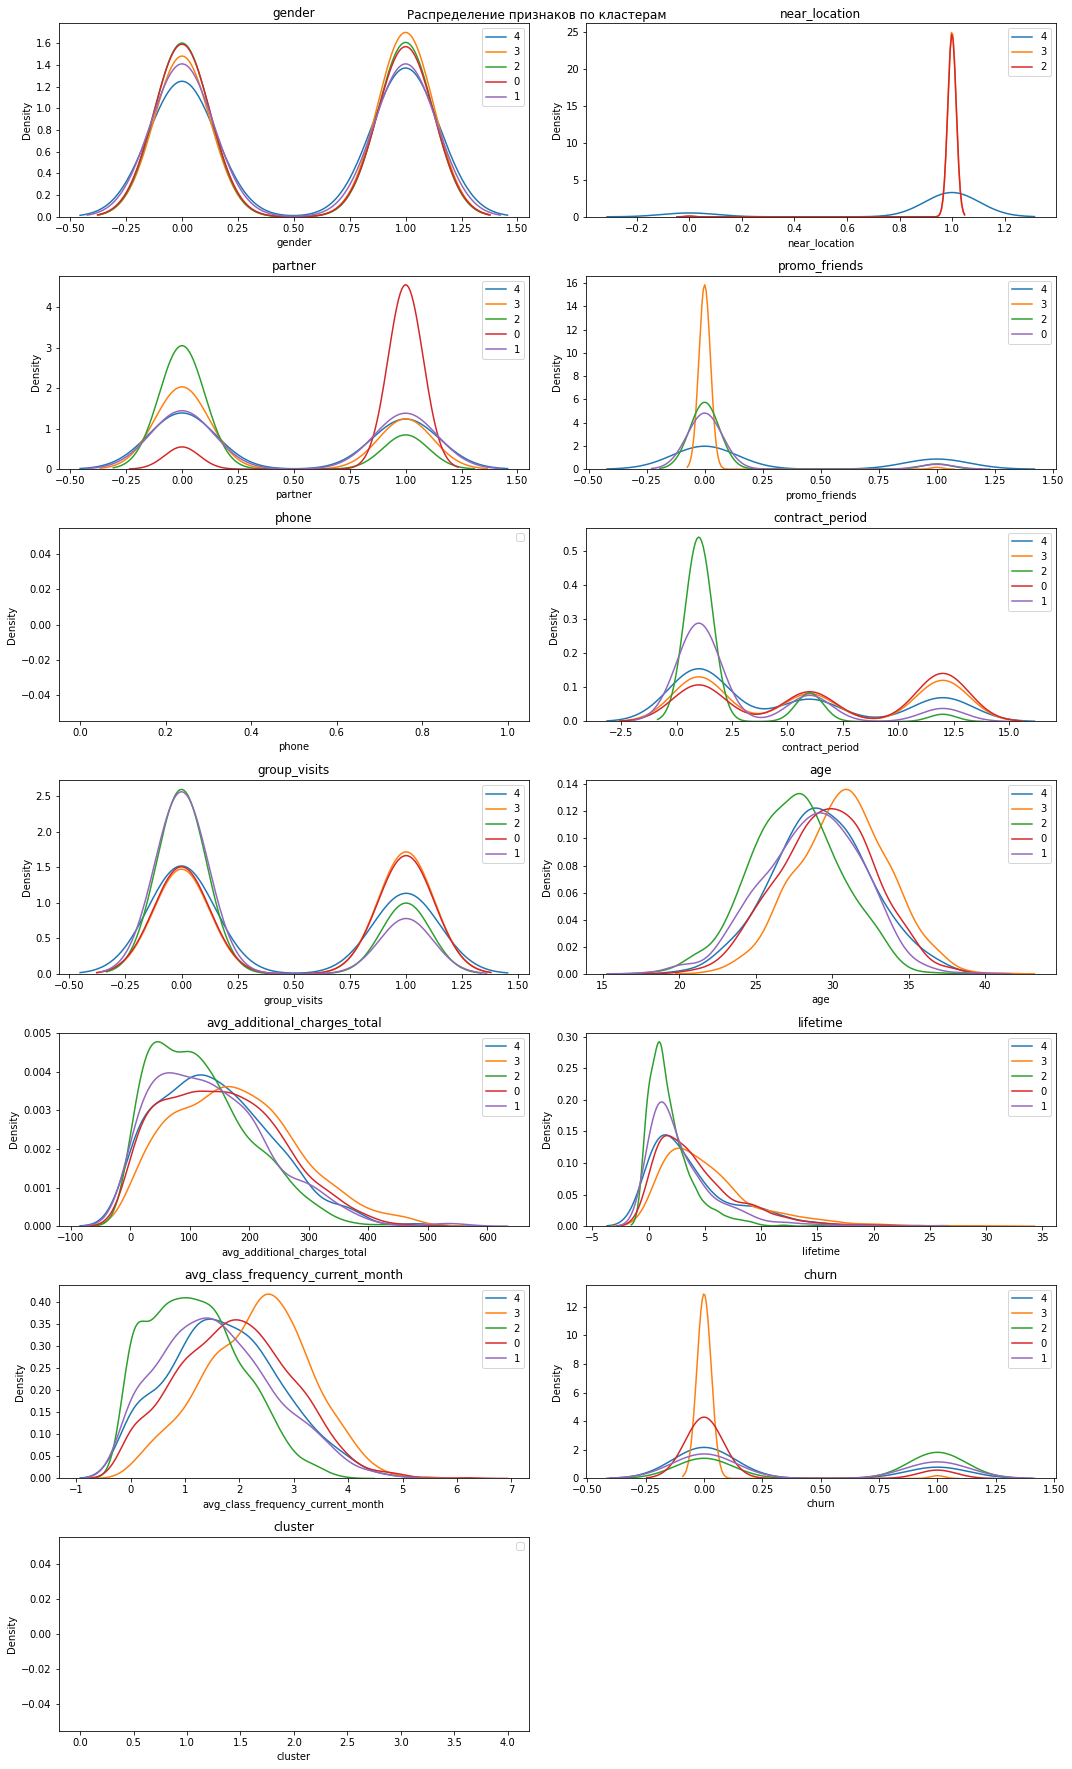

In [31]:
col_count, row_count = 2, 7
plt.figure(figsize=(15, 25))
for i, j in enumerate(df_filtered.columns):
    for cluster in df_filtered['cluster'].unique():
        current = df_filtered.query('cluster == @cluster')
        sns.distplot(current[j],hist=False, ax=plt.subplot(row_count, col_count, i+1))      
    plt.title(j) 
    plt.legend(df_filtered['cluster'].unique())
plt.suptitle('Распределение признаков по кластерам')
plt.tight_layout()

## Выводы и рекомендации 

Исходный датасет состоит из 4000 строк и 14 столбцов.
В ходе исследовательского аналиха данных были получены следующие результаты:
- Пол распределен клиентов распределен примерно поровну;
- Преобладают клиенты проживающие или работающие в районе, где находится фитнес-центр (85%);
- Клиент является сотрудником компании-партнёра клуба, примерно в половине случаев;
- 31% клиентов использовали промо-код от знакомого при оплате первого абонемента в рамках акции «приведи друга».
- 90% клиентов оставляют контактный номер телефона;
- Преобладают клиенты с контрактом на 1 месяц.
- 41% клиентов посещают групповые занятия.
- Средний возраст клиентов - 29 лет.
- Средняя суммарная выручка от других услуг фитнес-центра - 147 у.е.
- Наиболее распрастраненный срок до окончания текущего действующего абонемента - 1 мес., средный срок до окончания абонемента - 4,3 мес.
- Среднее время с момента первого обращения в фитнес-центр клиентов - 3,72 мес.
- Средняя частота посещений в неделю за все время с начала действия абонемента - 1,88 в неделю.
- Средняя частота посещений в неделю за предыдущий месяц;ц - 1,77 в неделю.
- 26% отток клиентов в текущем месяце.  

Среднее значение возраста клиентов попавших в отток меньше, чем  у оставшихся клиентов.  
Средняя суммарная выручка от других услуг фитнес-центра у оставшихся клиентов выше.   
Наиболее частый срок до окончания текущего действующего абонемента у клиентов папавших в отток - 1 мес.  
Наибольлее частое время с момента первого обращения в фитнес-центр, у тех кто ушёл каже 1 мес.  
Средняя частота посещений в неделю за все время с начала действия абонемента и средняя частота посещений в неделю за предыдущий месяц у оставшихся клиентов выше.

Была постоена матрица корреляция, по ней замечено, что сильно коррелирую следующие признаки:  
- Month_to_end_contract - Contract_period (срок до окончания текущего действующего абонемента (в месяцах) - длительность текущего действующего абонемента (месяц, 6 месяцев, год));  
- Avg_class_frequency_total - Avg_class_frequency_current_month (средняя частота посещений в неделю за все время с начала действия абонемента -  средняя частота посещений в неделю за предыдущий месяц).    
Произведено удаление по одному из коррелирующих признаков,  чтобы избавиться от мультиколлинеарности.

Были построены модели бинарной классификации клиентов по факту оттока клиентов в следующем месяце, двумя способами:
логистической регрессией и случайным лесом.

Проведена кластерицация клиентов. В ходе которой, были выделены 4 группы клиентов, в двух из которых высокой процент оттока. У группы №2 56% оттока, у группы №1 - 40%. Эти группы характеризуются минимальными значениями по всем признакам. С одним отличием, что в группе №1 процент клиентов проживающих или работающих в районе, где находится фитнес-центр, равен 0, когда в группе №2 равен 100%. У этих групп практически совпадает среднее значение продолжительноти купленного абонемента и время, прошедшее с момента первого обращения в фитнес-центр (lifetime), т. е. люди перестают ходить в фитнесс, как только заканчивается абонемент, преимущественно, купленный на один месяц. Также в этих группах небольшой процент тех, кто пришёл по акции «приведи друга».   

Поэтому чтобы снизить долю оттока требуется:
- стимулировать клиентов к приобретению абонементов на более длительный срок (скидки на абонементы на 6 или 12 месяцев);
- более активно распространять акцию "приведи друга" и расширить бонусы от её использования при покупке абонемента. 